# SPR analysis class
## flow chart of important funcitons can be found in github repository

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import math
import tmm
import nidaqmx
import time 
import datetime 
import os 
from scipy.optimize import curve_fit



class new_model_SPR():
    """    
    This class is used in the system design project of developing a surface plasmon resonance sensor.  The sample being tested is
    solutions of sugar water of concentrations 0-20%. The key aspects of this code and a flow diagram of the relationships 
    can be found in the folder at //address github. To summarize this code is broken into 4 parts, theortical estimation of 
    the SPR resonance effect, Reading in data from the video and ADC input, (analogue to digital). Analysis of the data specifcally
    linear fitting, polynomial fitting, and a algorthin for finding the minimum intensity. Finally, a general puporse graphing 
    function is made for the user to construct graphs from the raw data provided in the folder. Addtionally, a set of specified 
    raw data can generate a sensetivity graph for the ADC and video methods. 

    Note if the user does not wish to read in their own data using a NI-6008 ADC converter. The following imports will be required
    to run this class. 

    -----------------------------
    (NOT REQURIED IF NO FURTHER DATA IS COLLECTED)

    nidaqmx: https://nidaqmx-python.readthedocs.io/en/latest/ 

    Instructions to install driver: https://knowledge.ni.com/KnowledgeArticleDetails?id=kA00Z0000019Pf1SAE&l=en-GB

    ------------------------------
    (REQUIRED FOR THEORTICAL COMPARISON)

    tmm package: https://pythonhosted.org/tmm/tmm.html 

    ------------------------------
    standard packages: 
    import time 
    import datetime 
    import os 
    import numpy as np
    import matplotlib.pyplot as plt
    import csv
    import math
    from scipy.optimize import curve_fit
    """

    def __init__(self, d_list, n_list, lam_vac):
        """
        Summmary
        ------------
        The initalisation object of the class new_model_SPR required for the theory calculation. Some other functions
        such as 'grapher' has an optional theory comparison but are object methods for convenience.
        
        
        Parameters
        ------------
        d_list: list
            the thickness of each material the incident light ray travels through. For example a typical
            structure in surface plasmon resonance sensors would consist of GLASS BK7 Prisim|| GOLD || WATER 
            and would have a d_list [math.inf, 50nm, math.inf]. Note the first and last
            values must be math.inf. The order of list is analogous to the path travelled through hence is not trivial.
        
        n_list: list 
            Permetivities of each of the materials the incident light ray travels through. For the 
            GLASS BK7||GOLD||WATER setup these are typical values n_list = [1.5168, 0.130+ 3.162j,1.326]. 
            
        lam_vac: int
            The wavelength of incident radiation. This is an important factor in observing strong surface plasmon
            resonance.
            
        Return
        ------------
        N/A
        
        
        """
        self.d_list = d_list
        self.n_list = n_list
        self.lam_vac = lam_vac

        
    
    ############### theory functions  #################

    def SPR_multi_layer(self):
        """
        Summmary
        ------------
        Theory function which calculates the entire reflectivity spectrum 0-90 in angular interrgation setup with the
        given inistalised model. 
        
        
        Parameters
        ------------
        N/A
            
        Return
        ------------
        Rp: ndarray
            Contains floats of the normalised Intensity of the entire reflectivity spectrum in the surface plasmon 
            resonnace. Size of 500.
            
        theta_list: ndarray
            Contains the arbitrary linearly spaced numpy array of size 500.
            
        Note
        ------------
        More information on this package and other examples can be found in tmm webpage linked below.
        
        https://pythonhosted.org/tmm/_modules/tmm/examples.html
    
        """
        lam_vac = self.lam_vac

        theta_list = np.linspace(0*(np.pi/180), 90*(np.pi/180), num=500)
        Rp = np.array([])
        for theta in theta_list:
            Rp = np.append(Rp, tmm.coh_tmm('p', self.n_list, self.d_list, theta, lam_vac)['R'])

        return Rp, theta_list


    ############ data reading in functions. ##############
    
    @staticmethod
    def angle_values(starting, ending, sample):
        """
        Summmary
        ------------
        As angle data is not read in automatically in the ADC method, due to the use of a manual rotary  encoder, 
        we instead opted to calculating the angle data over some given range specifed in each experimental measurmenet. 
        This is an estimate and assumes a constant rotation speed over the dynamic range specified. 
        
        Addtionally, by introducing a somewhat large timedelay in the ADC method, between each sample, we can determine 
        the average rotation speed over the dynamic range specified for comparison. 
        
        Parameters
        ------------
        starting: float 
            starting angle value, can be found in the metadata of datafiles. 
            
        ending: float 
            ending angle value can be found in metadata of datafiles. 
            
        sample:
            number of samples taken of the light intensity over the dyanmic range. 
            
        Return
        ------------
        angular_valeus: ndarray
            Contains the angular spectrum for the reflectivity for the ADC method. 
            
       """   
        angular_range = abs(starting-ending)
        step_size = angular_range/(sample)
        angular_values = np.arange(starting, ending, step = step_size )
        return angular_values
    
    
    @staticmethod
    def ADC(flag = 0, timedelay = 0.05):
        """
       
        Summmary
        ------------
        (NOT REQURIED IF NO FURTHER DATA IS COLLECTED)
        
        This function is used to read in the data from the NI-6008 Analogue to digital converter.
        The flag = 0 is a manual start and stop method
        the flag =1 is a set timmer method
        
        The key results were obtatined using flag = 0 due to manual rotation of stand and human error we do not sample the
        dynamic range at the same operation speed for each measurment. Hence, if operation speed is insufficent we may 
        not retiereve the entire dynamic range within a set time frame. Or if its too fast we obtain unnesccsary data 
        where no rotation occurs. In which case flag = 0 where the user can dynamically stop data input is more useful. 
        This reduces errors when calculating angular values over a given dynamic range, as we are allowed a variable 
        operation speed accounting for human error.
        
        Parameters
        ------------
        flag: int 
            The flag = 0 is a manual start and stop method
            the flag =1 is a set timmer method of timedelay*1000 = 50 seconds.
            
        timedelay: float 
            Delay between each sampled data point. This is required to obtain an opertation speed value and 
            
        Return
        ------------
        list2: ndarray
            Raw voltage values samped over the dynamic range with the NI-6008 Analouge to digital converter.
            
        i: int 
            number of sampled data over the dynamic range. 
        
        timedelay: float
            delay between each sampled data point
        
        starting: float 
            starting value as specified by the user found by measuring manual rotary encoder.
            
        ending: float 
            ending value as specified by the user found by measuring manual rotary encoder.
            
        rotation_sp: float
            Angular operation speed , found by (dynamic range)/(total time)
            
        concentration: int 
            user inputted concentration of measurand.
        
        """
        timedelay = timedelay # seconds
        list2 = np.array([])
        i= 0
        if flag  == 0:
        #Collecting data method 2 start and stop.
            try:
                with nidaqmx.Task() as task:
                    task.ai_channels.add_ai_voltage_chan("Dev1/ai0")
                    while True:
                        value  = task.read()
                        list2 = np.append(list2, value)
                        i +=1
                        if i%1000 == 0:
                            print("This many samples taken = {} ".format(i))
                        time.sleep(timedelay)
            except KeyboardInterrupt:
                print(" {} samples taken below are the values \n\n ".format(i))
                print(list2)
        if flag == 1:
            # collecting data method 1 set time frame timedelay * 1000 = 50 seconds. 
            with nidaqmx.Task() as task:
                task.ai_channels.add_ai_voltage_chan("Dev1/ai0")
                while(i != 1000):
                    #time.sleep(timedelay)  
                    if i%1000 == 0:
                        print("This many samples taken = {} ".format(i))
                    #no need for sleep func just take as many as possible, 
                    value  = task.read()
                    list2 = np.append(list2, value)
                    i+= 1
        
        starting = float(input("What is the starting angle?"))
        ending = float(input("What is the ending angle?"))
        concentration = float(input("What is the percent concentration of sugar?"))
        rotation_sp = (starting-ending)/(timedelay*i)
        print("You were rotating at degree/s = {}".format(rotation_sp))
        
        #Graph to check values.
        theta_values = new_model_SPR.angle_values(starting, ending, i)
        plt.plot(theta_values, list2/np.max(list2), 'o')
        plt.ylabel("reflxcivity normalised voltage")
        plt.xlabel("iterations angle (theta)")
        
        return list2, i , timedelay, starting, ending, rotation_sp, concentration
    
    @staticmethod
    def save_data(list2, i , timedelay, starting, ending, rotation_sp, concentration):
        """
        
        Summmary
        ------------
        After calling the ADC method use save_data to save the raw voltage values and metadata into a file path specificed 
        below. Where you must change the path of the file below into something appropriate for your PC.
            
        Parameters
        ------------
        list2: ndarray
            Raw voltage values samped over the dynamic range with the NI-6008 Analouge to digital converter.
            
        i: int 
            number of sampled data over the dynamic range. 
        
        timedelay: float
            delay between each sampled data point
        
        starting: float 
            starting value as specified by the user found by measuring manual rotary encoder.
            
        ending: float 
            ending value as specified by the user found by measuring manual rotary encoder.
            
        rotation_sp: float
            Angular operation speed , found by (dynamic range)/(total time)
            
        concentration: int 
            user inputted concentration of measurand.
            
        Returns
        ----------
        N/A
        
        """
        current_time = datetime.datetime.now()
        filename = "{}_{}_{}_num-".format(current_time.year, current_time.month, current_time.day)
        file_ext = ".csv"
        path = r"C:\Users\munee\System_design_stuff\Data\{}{}".format(filename, file_ext)
        uniq = 1
        while os.path.exists(path):
          path = 'C:/Users/munee/System_design_stuff/Data/%s%d%s' % (filename, uniq, file_ext)
          uniq += 1
        with open(path, "w") as csvfile:
            #metadata and header
            csvfile.write("""#time_and_date={}    
#concentration={}
#startingangle={}
#endingangle={}
#rotation_sp={}
#timedelay={}
#samplestaken={}

Raw voltage data\n""".format(current_time, concentration, starting, ending, rotation_sp, timedelay, i) )
            rows = ["{}".format(k) for k in list2]
            stringg = "\n".join(rows)
            csvfile.write(stringg)
        print("this is the file name = {}".format(path))

        
    @staticmethod
    def readin(path, flag = 0):
        """ 
        Summary
        ------------
        Function which reads in data from specified path. Where flag =1 it will read video data files. 
              
            
        Parameters
        ------------
        Path: str
            path specified on your PC
            
        flag: int 
            For flag =0 will read ADC data for flag =1 will read video data. Flag = 0 only returns 
            intensity data and metadata whereas video will return angular values also.
            
        Returns
        ----------
        yvalues: ndarray
            Contains the intensity value.
        
        metadata: {Dict}
            contains the following information about the collected data. An example seen below.
            
            #time_and_date=2023-03-09 11:39:10.690732    
            #concentration=0
            #startingangle=182.2
            #endingangle=191.9
            #rotation_sp=0
            #timedelay=0
            #samplestaken=12
            
        thetavalues: ndarray
            if flag =1 function will read the angular values in the video dataset.
        
        """
        if flag ==0:
            with open(path, "r") as file:
                i = 1
                yvalues = np.array([])
                metadata = {}
                for lines in file:
                    if i == 8 or i ==9:
                        i+=1
                        continue
                    if i<8:
                        data = lines.split('#')[1]
                        data = data.split('=')
                        metadata[data[0]] = data[1]
                        i+=1
                        continue
                    if i >=10:
                        yvalues = np.append(yvalues, float(lines))
                        i+=1
            return metadata, yvalues
        if flag ==1:
            with open(path, "r") as file:
                i = 1
                yvalues = np.array([])
                anglevalue = np.array([])
                metadata = {}
                change = 0
                for lines in file:
                    if i == 8 or i ==9:
                        i+=1
                        continue
                    if i<8:
                        data = lines.split('#')[1]
                        data = data.split('=')
                        metadata[data[0]] = data[1]
                        i+=1
                        continue
                    if i >=10:
                        if change == 1:
                            anglevalue = np.append(anglevalue, float(lines))
                        if change ==0:
                            if lines == "Raw Angle Value \n":
                                change =1
                                continue
                            
                            yvalues = np.append(yvalues, float(lines))
                            i+=1
                    
                            
            return metadata, yvalues, anglevalue
        
    @classmethod 
    def read_all_data(cls, labels, paths, analysis =0, p0=0):
        """ 
        Summary
        ----------
        This function reads in a set of data, given the specified paths, and allows the user to fit a lorentizan profile
        on all the data sets or paths provided.
        
            
        Parameters
        ------------
        labels: list
            User must specify the labels and paths in the same order, addtionally if one path is video 
            the label must indicate 'video xxxx' likewise 'ADC xxxx' with the ADC method.
            
        paths: list
            A list of all the paths in the same order as the labels.
            
        analysis: int
            setting analysis =1 will fit a mathematically appropriate function of a lorentizan on all the data sets
            or paths provided.
            
            
        Returns
        ----------
        data_list_all: list[ndarray,]
            Contains a python list which contains a 2d numpy array for each of the datasets. Where the first index is 
            thetavalues and second intensity values.
        
        concentration: int
            Contains the concentration of the dataset as specified in the metadata.
            
        data_fit: list[ndarray,]
            if analysis =1 each index contains the numpy array for the fitted data for each of the paths 
            specified. The first index of the ndarray contains popt values, for the lorentizan function used
            4 parameters are containted hence 'one_set = data_fit[0]''. 'popt= one_set[0]' and 'perr = one_set[1] '
            Where perr is the std error in each of the popt.
   
        """
        index = 0
        data_list_all = []
        concentration = np.array([])
        if analysis == 1:
            data_fit = []
        while len(paths) != index:
            label = labels[index]
            path = paths[index]
            if 'ADC' in label:
                metavalues, yvalue = cls.readin(path)
                start = float(metavalues['startingangle']) 
                end = float(metavalues['endingangle']) 
                i = float(metavalues['samplestaken'])
                concen = float(metavalues['concentration'])
                thetavalue = new_model_SPR.angle_values(start, end, i)
                thetavalue = thetavalue -114
                if thetavalue.size != yvalue.size:
                    thetavalue = thetavalue[:-1]
            if 'video' in label:
                metavalues, yvalue, thetavalue  = new_model_SPR.readin(path, 1)
                concen = float(metavalues['concentration'])
                thetavalue = thetavalue -114
            if analysis ==1:
                print(index)
                #normalise and baseline. 
                yvalue = yvalue/np.max(yvalue)
                popt, perr = cls.analysis_lorentz(thetavalue, yvalue, p0)
                print("The resonance angle of the peak '{}' is = {} ± {} ".format(labels[index], popt[1], perr[1]))
                print("The FWHM of peak '{}' is = {} ± {} \n\n ".format(labels[index], popt[2], perr[2]))
                fit_results = np.vstack([popt, perr])
                data_fit.append(fit_results)
            concentration = np.append(concentration, concen) 
            data = np.vstack([thetavalue, yvalue])
            data_list_all.append(data)
            index +=1
        if analysis ==1:
            return data_list_all, concentration, data_fit
        else:
            return data_list_all, concentration
      
    ############## analysis functions ##############

    @staticmethod
    def linear_func(x, a, c):
        """
        Summary
        ----------
        Simple line function in the form of y = mx+c. Used in the sensetivity calculation of 
        y(theta) = mx(refractive index) + c 
        
            
        Parameters
        ------------
        x: array, float, int
            Input array, float , and or int. 
        a: float, int
            gradient of the line. 
        c: float, int 
            y intercept.
            
        Returns
        ----------
        y: array, float, int
            yvalues of the function y =mx+c

        """
        return (a*x)+ c
 
    @staticmethod
    def Lorentz(theta,amp, cen, wid, d):
        """

        Summary
        ----------
        Upsidedown Lorentzian fucntion used for fitting the peak dip in the surface plasmon resonance
        
            
        Parameters
        ------------
        theta: int, float, array
            the angular spectrum which is sampled.
            
        amp: float, int 
            height of the main peak. 
            
        cen: float, int
            position of the main peak centered.
            
        wid: float, int 
            FWHM of the main peak 
            
        d: float, int
            correction factor after inversion of Lorentzian.
            
        Returns
        ----------
        y: array, float, int
            yvalues of the Lorentzian function

    
        """
        return -(amp*wid**2/((theta-cen)**2+wid**2)) +d
        
    @staticmethod
    def analysis_lorentz(theta, yvalues, p0):
        """
        Summary
        ----------
        Function which analyizes the dataset and returns the fitting parameters.
        
            
        Parameters
        ------------
        theta: ndarray
            Angular spectrum sampled
            
        yvalues: ndarray
            reflectivity
            
        p0: list
            inital guess of the paramaters
            
        Returns
        ----------
        popt: list
            fitting parameters from the lotentzian function.
            
        perr: list
            error in parameters.

        """

        popt, pcov = curve_fit(new_model_SPR.Lorentz, theta, yvalues, p0)
        perr = np.sqrt(np.diag(pcov))
        
        return popt, perr
        
    @staticmethod
    def sensitivity(x, y):
        """
        Summary
        ----------
        Function which calculates the gradient of the fitted data in a sensetivity graph. (resonance angle against 
        refractive index). Takes the angular resolution of the manual rotary encoder of 0.1°. Which is the dominant noise
        factor upon analysis.
        
        Parameters
        ------------
        x: ndarray
            Angular spectrum
        
        y: ndarray
            Light intensity
            
        Returns
        ----------
        gradient: float
            gradient of linearly fitted data
            
        perr: float
            error in gradient.
        """
        #curvefit linear 
        sigma = np.repeat(0.1, x.size)
        popt, pcov = curve_fit(new_model_SPR.linear_func,x,y, sigma = sigma , absolute_sigma = True)
        gradient = popt[0]
        perr = np.sqrt(np.diag(pcov))
        return gradient, perr[0]
    
    
    @staticmethod
    def RI_calculate(concentration):
        """
        Summary:
        ----------------
        An empirical function to find refractive index given some concentration value. indepedant emperiical refractive index 
        measurement not taken hence using relationship provided hence taken from
        https://www.researchgate.net/publication/326377418_Concentration_Wavelength_and_Temperature_Dependent_Refractive_Index_of_Sugar_Solutions_and_Methods_of_Determination_Contents_of_Sugar_in_Soft_Drink_Beverages_using_Laser_Lights
        for  the red diode laser. 
        
        Parameters:
        ----------------
        Concentration: float, int, ndarray
            concentration value of measurand as a % percentage.
            
        Returns
        ----------------
        RI: float, int, ndarray
            refractive index found from empirical relationship. 
    
        """

        
        return concentration*1.65*(10**-3)+1.3270
        
    

    ############## graphing functions ##############

    def grapher(self,labels, paths , theory = 0,startingx = 50, endingx=90,fit = 0, p0= [1,74, 2.7, 1]):
        """
        Summary
        ----------
        Function which creates a graph of specified paths. Labels must be in the same order as paths. 
        
            
        Parameters
        ------------
        labels: list
            User must specify the labels and paths in the same order, addtionally if one path is video 
            the label must indicate 'video xxxx' likewise 'ADC xxxx' with the ADC method.
            
        paths: list
            A list of all the paths in the same order as the labels.
        
        theory: int 
            Plots the theortical angular reflectivity pattern for comparsion when theory =1. Given the model
            initalised.
            
        fit: int
            setting fit =1 will fit a mathematically appropriate function of a lorentizan on all the data sets
            or paths provided and plot them.
        
        startingx: int 
            Allows the user to manually adjust the graph starting angle. 
        
        endingx: int
            Allows the user to manually adjust the graph ending value 
            
        p0: list 
            if fit =1 must provide an appropriate inital guess. 
            
            
        Returns
        ----------
        N/A
   
        """
        if fit ==1:
            full_data_list, concen, data_fit= self.read_all_data(labels, paths, fit, p0)
        if fit ==0:
            full_data_list, concen = self.read_all_data(labels, paths)
        i =0
        for data in full_data_list:
            thetavalues = data[0]
            yvalues = data[1]
            yvalues = yvalues/np.max(yvalues)
            if 'video' in labels[i]:
                plt.plot(thetavalues, yvalues,**{'marker': 'o'}, label = labels[i])
            if 'ADC' in labels[i]:
                plt.plot(thetavalues, yvalues, label = labels[i])
            if fit ==1:
                data_one_fit = data_fit[i]
                y_fit = self.Lorentz(thetavalues, data_one_fit[0][0], data_one_fit[0][1], data_one_fit[0][2], data_one_fit[0][3])
                
                plt.plot(thetavalues,y_fit, label = "fitted {}".format(labels[i]))
            i+=1
        if theory ==1:
            Rp, thetavalues = self.SPR_multi_layer()
            plt.plot(thetavalues*(180/np.pi), Rp, label = "theory")
        plt.legend()
        plt.xlabel("Angle (Degrees)", fontsize = 20)
        plt.xticks(fontsize=20)
        plt.ylabel("Intensity (Normalised)", fontsize = 20)
        plt.yticks(fontsize=20)
        plt.title("Reflectivity against angle", fontsize = 20)
        plt.rcParams["figure.figsize"] = (8,6)
        plt.locator_params(axis='x', nbins=15)
        plt.legend(fontsize = 10)
        plt.xlim(startingx, endingx)
        
    @classmethod
    def line_grapher2(cls,method, labels=0, paths=0, manual_input =[], concen_manual=[], p0 = [1,74, 2.7, 1], theory_object =0):
            """
            Summary
            ----------
            Graphing function which creates the sensetivity plot. (Resonance angle against refractive index). For the 
            labels and paths provided. Must provide two sets of labels and paths. One set should be purley ADC and the 
            other purley video to avoid confusion. 


            Parameters
            ------------
            labels: list
                User must specify the labels and paths in the same order, addtionally if one path is video 
                the label must indicate 'video xxxx' likewise 'ADC xxxx' with the ADC method.

            paths: list
                A list of all the paths in the same order as the labels.

            manual_input: ndarray
                If user wants to input their own minimum resonance values. Order must be same in cocen_manual

            concen_manual: ndarray
                if user wants to input their own concentration values. Order must be the same as manual_input.

            p0: list 
                 Inital guess to obtain fit. This allows the calculation of the resonance angle and other fitting 
                 parameters

            theory_object: new_model_SPR instance
                If an initalised object is provieded in this optional parameter it will plot the theortical change in 
                resonance angle with a change in refractive index.


            Returns
            ----------
            N/A

            """
            if len(manual_input) ==0:
                all_data, concen, data_fit = cls.read_all_data(labels, paths, analysis =1, p0=p0)
                resonance_angles1 =[]
                for data_one_fit in data_fit:
                    #selecting popt then resonance value.
                    resonance_angle1 = data_one_fit[0][1]
                    resonance_angles1.append(resonance_angle1)
                RI_list_from_paper = cls.RI_calculate(concen)
                grad, err = cls.sensitivity(RI_list_from_paper, resonance_angles1)
                plt.plot(RI_list_from_paper, resonance_angles1, **{'marker': 'o'}, label=method)
            if len(manual_input) != 0:
                RI_list_from_paper = cls.RI_calculate(concen_manual)
                grad, err = cls.sensitivity(RI_list_from_paper, manual_input)
                plt.plot(RI_list_from_paper, manual_input, **{'marker': 'o'}, label=method)
                
            print("""\n=============================
This is the linear fitted gradient of the '{}' method {} ± {}
=============================\n""".format(method ,grad, err))
            if isinstance(theory_object, new_model_SPR):
                values = np.linspace(1.32, 1.36, 30)
                min_theory =[]
                for i in values:
                    theory_object.n_list[-1] = i
                    Rp, thetavalue =theory_object.SPR_multi_layer()
                    min_y_index = np.argmin(Rp)
                    resonance_angle_theory=(180/np.pi)*thetavalue[min_y_index]
                    min_theory.append(resonance_angle_theory)
                    
                plt.plot(values, min_theory, **{'marker': 'o'}, label = 'theory')
                grad_theory, err_theory = cls.sensitivity(values, min_theory)
                print("""\n=============================
This is the linear fitted gradient of the theory method {} ± {} 
=============================\n""".format(grad_theory, err_theory))
            plt.legend()
            plt.xlabel("Refractive Index ", fontsize = 20)
            plt.xticks(fontsize=20)
            plt.ylabel("Resonance angle (°)", fontsize = 20)
            plt.yticks(fontsize=20)
            plt.title("Resonance angle against Refractive index", fontsize = 20)
            plt.rcParams["figure.figsize"] = (8,6)
            plt.locator_params(axis='x', nbins=7)
            plt.legend(fontsize = 10)

## Comparison of BK7 prisim and Unkown refractive index prisim. 


An interesting comparison is with the BK7 glass prisim and the unkown refractive index glass used initally. The effect on the reflexcivity dip was noticeable by eye. This effect was also reported by and described by [14],
(bibilography in the system design project). According to Ashrafi [14] the BK7 prisim compared to higher refractive index alternatives is more sensetive. The sensetivity increases with a lower refractive index which can be atributed to a decrease in the damping of the surface wave. [9].This has the effect of a longer propogation distance of the surface plasmon which can cause a sharper more sensetive peak. Also, Ashrafi et all find higher refractive index prisims to shift 
the resonance peak to lower values. As seen in the following figure it suggests a lower unknown refractive index prisim.


  
Note in the following figure BK7 has a larger FWHM but a steeper depth compared to the more sensetive unknown RI. This may be due to a difference in coupling conditions. Where at optimal coulping we expect more absorption hence a deeper peak.
The following equation describes the FWHM of the surface plasmon peak when coupling is optimal as shown by [9] Homola. 

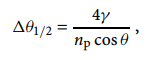
 
Linking in with surface plasmon pg 39 [9]. The reflectivity is most apprioatley defined by a mathetmatical lorentizan 
funciton, due to the this mathemtical link we can derive real information from its analysis. In this case indications on 
coupling strength and also propogation length of the surface plasmon wave. Note a Lorentzian profile is taken however surface plasmon resonance exhibts asymmetry at lower thickness values hence is not an ideal fit but a good physcial approximation. 



## References. (From System Design Report)
[9] Homola, J. Springer. (2006). Springer Series on Chemical Sensors and Biosensors. [online] Available at:
https://www.springer.com/series/5346.

[14]Ashrafi, T.M.S. and Mohanty, G. (2022). Sensitivity calculation for different prism material
based surface plasmon resonance sensor: a comparative study. Journal of Physics: Conference
Series, 2267(1), p.012089. 


0
The resonance angle of the peak 'ADC Pure water BK7 prisim' is = 72.49101220022794 ± 0.0627003732335132 
The FWHM of peak 'ADC Pure water BK7 prisim' is = 1.942189472478645 ± 0.15622348683091958 

 
1
The resonance angle of the peak 'ADC Pure water unkown RI prisim' is = 72.72958963345849 ± 0.18577974060800012 
The FWHM of peak 'ADC Pure water unkown RI prisim' is = -0.5341293783096752 ± 0.30634356232249377 

 


Text(0.5, 1.0, 'Reflectivity of BK7 and unknown RI prisim with theory, ADC')

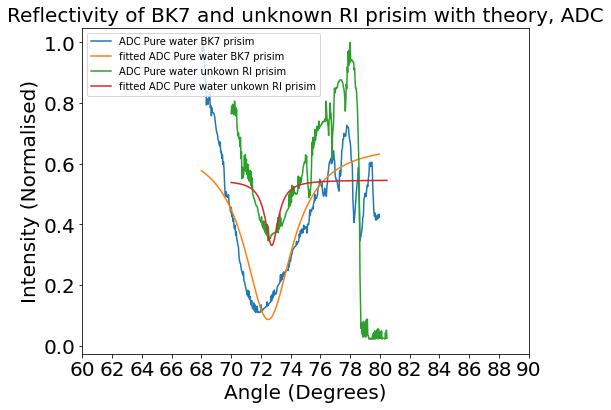

In [25]:
# gold model. 
#|| PRISIM GLASS || GOLD || PURE WATER 


n_list = [1.5168, 0.130+ 3.162j,1.326]
d_list = [math.inf, 50, math.inf]


#Path travelled by light ray, order of materials and their thickness 'd_list' and refractive index n_list, wavelength laser.
gold_model = new_model_SPR(d_list, n_list, 633)

#resonable estimate of fitting values if fit = 1
p0 = [1,74, 2.7, 1]


labels = ['ADC Pure water BK7 prisim', 'ADC Pure water unkown RI prisim']
paths = ["C:/Users/munee/System_design_stuff/Data/2023_3_9_num-.csv", 
         "C:/Users/munee/System_design_stuff/Data/2023_3_6_num-2.csv"]

gold_model.grapher(labels, paths, startingx = 60,theory =0, fit =1, p0 = p0)
plt.title("Reflectivity of BK7 and unknown RI prisim with theory, ADC", fontsize = 20)


##  Comparison of ADC and video methods with theory single concentration


Text(0.5, 1.0, 'Reflectivity comparsion of ADC and video methods with theory')

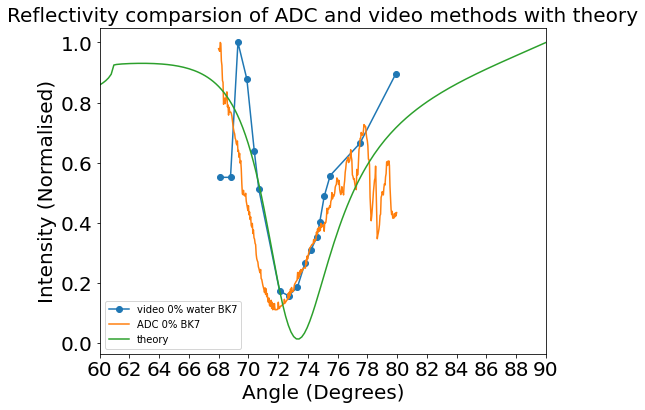

In [5]:
         
labels = ['video 0% water BK7', 'ADC 0% BK7']
paths = ['C:/Users/munee/System_design_stuff/Data_video/Data_3_9_0%.txt',
         'C:/Users/munee/System_design_stuff/Data/2023_3_9_num-.csv']

gold_model.grapher(labels, paths,theory=1, startingx= 60)
plt.title("Reflectivity comparsion of ADC and video methods with theory", fontsize = 20)




## 0-20% sugar water concentration ADC 

Text(0.5, 1.0, 'Reflectivity 0-20% sugar water concentration ADC ')

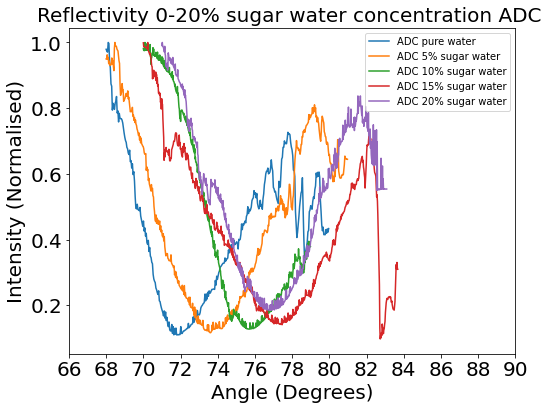

In [7]:

labels = ['ADC pure water', 'ADC 5% sugar water', 'ADC 10% sugar water', 'ADC 15% sugar water',
         'ADC 20% sugar water']
          
paths = ["C:/Users/munee/System_design_stuff/Data/2023_3_9_num-.csv", #pure water
"C:/Users/munee/System_design_stuff/Data/2023_3_9_num-2.csv", # 5% 
"C:/Users/munee/System_design_stuff/Data/2023_3_9_num-4.csv", #10%     
"C:/Users/munee/System_design_stuff/Data/2023_3_9_num-5.csv", #15%
"C:/Users/munee/System_design_stuff/Data/2023_3_9_num-8.csv" # 20%
        ]
gold_model.grapher(labels, paths, fit = 0, p0=p0, startingx = 66)

plt.title("Reflectivity 0-20% sugar water concentration ADC ", fontsize = 20)

## 0-20% sugar water concentration video

Text(0.5, 1.0, 'Reflectivity 0-20% sugar water concentration video ')

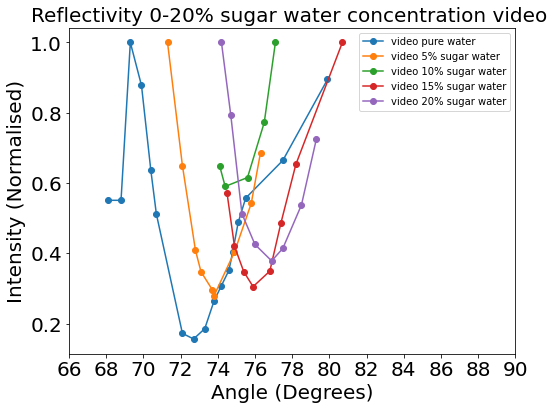

In [8]:
labels = ['video pure water', 'video 5% sugar water', 'video 10% sugar water', 'video 15% sugar water',
         'video 20% sugar water']
          
paths = ["C:/Users/munee/System_design_stuff/Data_video/Data_3_9_0%.txt", #pure water
         "C:/Users/munee/System_design_stuff/Data_video/Data_3_9_5%.txt", # 10% 
"C:/Users/munee/System_design_stuff/Data_video/Data_3_9_10%.txt", # 10% 
"C:/Users/munee/System_design_stuff/Data_video/Data_3_9_15%.txt", #15%     
"C:/Users/munee/System_design_stuff/Data_video/Data_3_9_20%.txt", #20%
]
gold_model.grapher(labels, paths,startingx = 66, fit =0, p0=p0)

plt.title("Reflectivity 0-20% sugar water concentration video ", fontsize = 20)

## Performance test - Sensetivity comparison of ADC and video methods with theory.

Note in the system design report more percise RI values were taken from [1] of  [1.3264, 1.3357, 1.3448, 1.3532, 1.3584] for concentrations of 0% , 5%, 10%, 15%, 20% sugar water for red diode laser. Instead of the callibration empirical equation used in new_model_SPR.RI_calculate also given from [1].



## References. 
[1] A, B. and G, A. (2018). Concentration, Wavelength and Temperature Dependent Refractive Index of Sugar Solutions and Methods of Determination Contents of Sugar in Soft Drink Beverages using Laser Lights. Journal of Lasers, Optics & Photonics, [online] 05(02). 




This is the linear fitted gradient of the 'detector_by_eye' method 172.1212065855862 ± 3.833063774328203

0
The resonance angle of the peak 'ADC pure water' is = 72.49101220022794 ± 0.0627003732335132 
The FWHM of peak 'ADC pure water' is = 1.942189472478645 ± 0.15622348683091958 

 
1
The resonance angle of the peak 'ADC 5% sugar water' is = 74.07433406862044 ± 0.03500840266651938 
The FWHM of peak 'ADC 5% sugar water' is = 3.7208454964607403 ± 0.166397728530095 

 
2
The resonance angle of the peak 'ADC 10% sugar water' is = 76.22992007022133 ± 0.015702897156594082 
The FWHM of peak 'ADC 10% sugar water' is = 5.0922733701457625 ± 0.10927129902868611 

 
3
The resonance angle of the peak 'ADC 15% sugar water' is = 78.17124864278429 ± 0.07854924144401734 
The FWHM of peak 'ADC 15% sugar water' is = 443.3985752299961 ± 32558.454958099475 

 
4
The resonance angle of the peak 'ADC 20% sugar water' is = 76.91470394047577 ± 0.027397439656171876 
The FWHM of peak 'ADC 20% sugar water' is =

C:\Users\munee\AppData\Local\Temp\ipykernel_22116\306542523.py:582: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))


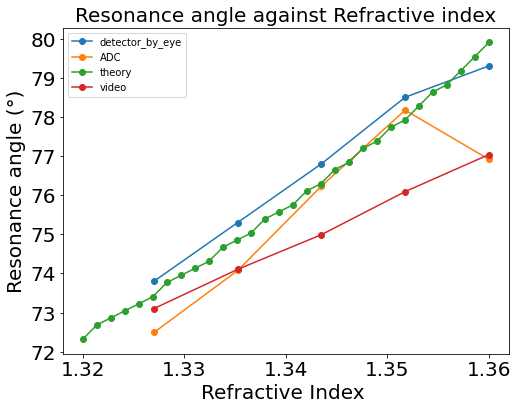

In [24]:

n_list = [1.5168, 0.130+ 3.162j,1.326]
d_list = [math.inf, 50, math.inf]
gold_model = new_model_SPR(d_list, n_list, 633)



labels_ADC_BK7 = ['ADC pure water', 'ADC 5% sugar water', 'ADC 10% sugar water', 'ADC 15% sugar water', 'ADC 20% sugar water']

paths_ADC = ["C:/Users/munee/System_design_stuff/Data/2023_3_9_num-.csv", #pure water
"C:/Users/munee/System_design_stuff/Data/2023_3_9_num-2.csv", # 5% 
"C:/Users/munee/System_design_stuff/Data/2023_3_9_num-4.csv", #10%     
"C:/Users/munee/System_design_stuff/Data/2023_3_9_num-5.csv", #15%
"C:/Users/munee/System_design_stuff/Data/2023_3_9_num-8.csv"] # 20%

labels_video = ['video pure water', 'video 5% sugar water', 'video 10% sugar water', 'video 15% sugar water',
         'video 20% sugar water']
          
paths_video = ["C:/Users/munee/System_design_stuff/Data_video/Data_3_9_0%.txt", #pure water
         "C:/Users/munee/System_design_stuff/Data_video/Data_3_9_5%.txt", # 10% 
"C:/Users/munee/System_design_stuff/Data_video/Data_3_9_10%.txt", # 10% 
"C:/Users/munee/System_design_stuff/Data_video/Data_3_9_15%.txt", #15%     
"C:/Users/munee/System_design_stuff/Data_video/Data_3_9_20%.txt", #20%
]

detector_by_eye_min_values = np.array([73.8,75.3,76.8,78.5,79.3])
concen_= np.array([0,5,10,15,20])

new_model_SPR.line_grapher2('detector_by_eye', manual_input = detector_by_eye_min_values, concen_manual = concen_)
new_model_SPR.line_grapher2('ADC', labels_ADC_BK7, paths_ADC, theory_object = gold_model)
new_model_SPR.line_grapher2('video', labels_video, paths_video)



# Performance testing - Sensetivity comparison Unknown RI prisim and BK7 with ADC method


As reported by Ashrafi et all [14] and Guo-ping et all[1] a lower refractive index material will yeild a higher sensetivity 
where we find the the unkown refractive index to be more senseitive. In the future use of alternative methods apart from ADC should be used. Where other methods are shown to be more accurate. 

## References. (From System Design Report)
[9] Homola, J. Springer. (2006). Springer Series on Chemical Sensors and Biosensors. [online] Available at:
https://www.springer.com/series/5346.

[14]Ashrafi, T.M.S. and Mohanty, G. (2022). Sensitivity calculation for different prism material
based surface plasmon resonance sensor: a comparative study. Journal of Physics: Conference
Series, 2267(1), p.012089. 


## Other references
[1] Guo-ping, W., Tadao, S. and Satoshi, K. (2002). Sensitivity dependence of surface plasmon resonance based sensors on prism refractive index. Wuhan University Journal of Natural Sciences, 7(1), pp.47–50. 

0
The resonance angle of the peak 'ADC pure water' is = 72.49101220022794 ± 0.0627003732335132 
The FWHM of peak 'ADC pure water' is = 1.942189472478645 ± 0.15622348683091958 

 
1
The resonance angle of the peak 'ADC 5% sugar water' is = 74.07433406862044 ± 0.03500840266651938 
The FWHM of peak 'ADC 5% sugar water' is = 3.7208454964607403 ± 0.166397728530095 

 
2
The resonance angle of the peak 'ADC 10% sugar water' is = 76.22992007022133 ± 0.015702897156594082 
The FWHM of peak 'ADC 10% sugar water' is = 5.0922733701457625 ± 0.10927129902868611 

 
3
The resonance angle of the peak 'ADC 15% sugar water' is = 78.17124864278429 ± 0.07854924144401734 
The FWHM of peak 'ADC 15% sugar water' is = 443.3985752299961 ± 32558.454958099475 

 
4
The resonance angle of the peak 'ADC 20% sugar water' is = 76.91470394047577 ± 0.027397439656171876 
The FWHM of peak 'ADC 20% sugar water' is = 3.2329245692421362 ± 0.12112429458974953 

 

This is the linear fitted gradient of the 'ADC BK7' method 1

C:\Users\munee\AppData\Local\Temp\ipykernel_22116\306542523.py:582: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))


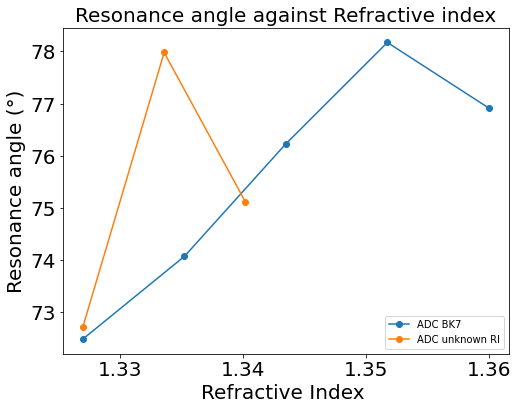

In [26]:
labels_BK7 = ['ADC pure water', 'ADC 5% sugar water', 'ADC 10% sugar water', 'ADC 15% sugar water', 'ADC 20% sugar water']

paths_BK7 = ["C:/Users/munee/System_design_stuff/Data/2023_3_9_num-.csv", #pure water
"C:/Users/munee/System_design_stuff/Data/2023_3_9_num-2.csv", # 5% 
"C:/Users/munee/System_design_stuff/Data/2023_3_9_num-4.csv", #10%     
"C:/Users/munee/System_design_stuff/Data/2023_3_9_num-5.csv", #15%
"C:/Users/munee/System_design_stuff/Data/2023_3_9_num-8.csv"] # 20%


labels_unknown_RI = ['ADC pure water', 'ADC 4% sugar water', 'ADC 8% sugar water']
          
paths_unknown_RI = ["C:/Users/munee/System_design_stuff/Data/2023_3_6_num-2.csv", #pure water
         "C:/Users/munee/System_design_stuff/Data/2023_3_6_num-4.csv", # 4% 
"C:/Users/munee/System_design_stuff/Data/2023_3_6_num-5.csv"] # 8% 


new_model_SPR.line_grapher2('ADC BK7', labels_BK7, paths_BK7)
new_model_SPR.line_grapher2('ADC unknown RI', labels_unknown_RI, paths_unknown_RI)



# Performance testing - Linearity of refractometric sensor. 


As the relationship between the refractive index and concentration is only linear within a certain range it is important to consider for callibration purposes. An indepednat refractive index measurent of the water was not taken hence the relationship is taken which follows the callibration curve described in [1].


In the future the method descirbed by Grange et all [2] can be used where a hollow prisim filled with water is analyzed with snells law to find indepedant refractive index measurments at different concentrations. Other callibration testing is needed for the alpha prototpye such as tempreture dependant effects which can affect the performance signficiantly. 


## Other references. 
[1] A, B. and G, A. (2018). Concentration, Wavelength and Temperature Dependent Refractive Index of Sugar Solutions and Methods of Determination Contents of Sugar in Soft Drink Beverages using Laser Lights. Journal of Lasers, Optics & Photonics, [online] 05(02). 

[2]B. W. Grange, W. H. Stevenson, and R. Viskanta. (1976). "Refractive
Index of Liquid Solutions at Low Temperatures: An Accurate
Measurement," Appl. Opt. 15, 858 